
# Bank Marketing — End‑to‑End Classification Workflow (LogReg & LightGBM + SMOTE)

This notebook walks through a complete, **explainable** modeling workflow for the classic Bank Marketing dataset.
It covers:

1. Loading the data and inspecting class balance  
2. Preprocessing (scaling numeric features, one‑hot encoding categorical features)  
3. Train/test split with stratification  
4. A **Logistic Regression** pipeline with threshold tuning and evaluation  
5. Batch scoring a second file (`bank.csv`)  
6. A **LightGBM** model trained on **SMOTE**-balanced data, with a recall‑aware threshold

Each code cell is heavily commented to explain *what* the command does and *why* it's used.



> **Optional (Colab/fresh env):** If you're running this in a new environment, you may need to install dependencies.
Uncomment and run the cell below.


In [21]:

# Uncomment to install if needed
!pip install pandas numpy scikit-learn seaborn matplotlib lightgbm imbalanced-learn



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\TS0705\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



## 1) Imports & Global Settings

We import the core scientific Python stack and ML libraries.  
- `pandas`/`numpy` for data handling  
- `scikit-learn` (preprocessing, models, metrics, pipeline)  
- `seaborn`/`matplotlib` for quick visual diagnostics  
- `lightgbm` for gradient boosting  
- `imblearn` for **SMOTE** (oversampling minority class)


In [22]:

import pandas as pd
import numpy as np

# Plotting libraries — used for visualization/diagnostics
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing + modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

# Gradient boosting + Oversampling
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2) Load Dataset

We read the **Bank Marketing** dataset (`bank-full.csv`) which is typically in `;`-separated (semicolon) format.  
- `sep=";"` ensures correct parsing.  
- We print the shape and the first few rows to verify loading.


In [23]:

# Path to the training dataset (adjust if needed for your environment)
dataset_path = "bank\\bank-full.csv"

# Load data; the dataset uses semicolons as delimiters
data = pd.read_csv(dataset_path, sep=";")

print("Dataset Shape:", data.shape)
print("\nPreview of raw dataset (first 5 rows):")
display(data.head())


Dataset Shape: (45211, 17)

Preview of raw dataset (first 5 rows):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



## 3) Inspect Target Distribution (Class Balance)

The target column **`y`** indicates whether the client subscribed to a term deposit:
- `"yes"` → positive class (1)  
- `"no"` → negative class (0)

We compute **relative frequencies** (`normalize=True`) to understand class imbalance.  
This informs decisions like **class weights**, **SMOTE**, and **threshold tuning**.


In [24]:

print("Current Class Balance (proportions):")
class_balance = data['y'].value_counts(normalize=True)
display(class_balance)


Current Class Balance (proportions):


y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


## 4) Encode Target as Numeric

Most ML estimators expect numeric targets. We map:
- `yes → 1`
- `no → 0`

We also quickly re‑preview the data to confirm the change.


In [25]:

data['y'] = data['y'].map({'yes': 1, 'no': 0})
print("Unique values in y after mapping:", data['y'].unique())
display(data.head())


Unique values in y after mapping: [0 1]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0



## 5) Separate Feature Types (Categorical vs Numeric)

We identify:
- **Categorical columns** (`dtype=object`) → need one‑hot encoding  
- **Numeric columns** (`dtype number`) → often benefit from scaling

We exclude the target `y` from the numeric list.


In [26]:

cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(include=np.number).columns.tolist()

# Remove the target from features
if 'y' in num_cols:
    num_cols.remove('y')

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']



## 6) Preprocessing Pipeline (`ColumnTransformer`)

We build a **single transformer** that will handle both numeric and categorical features:

- `StandardScaler` on numeric columns: centers/scales features for models sensitive to feature magnitude.  
- `OneHotEncoder` on categorical columns: creates binary indicator columns per category.

**Why `drop="first"`?**  
- It drops one category per feature to avoid perfect multicollinearity (useful for linear models like Logistic Regression).

**Why `handle_unknown="ignore"`?**  
- Avoids errors at inference if a previously unseen category appears; the encoder will emit zeros for it.


In [27]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)



## 7) Train/Test Split (Stratified)

We split data into **train (80%)** and **test (20%)** while **preserving class proportions** using `stratify=y`.
This ensures fair evaluation on the imbalanced dataset.


In [28]:

X = data.drop('y', axis=1)  # Features (all columns except the target)
y = data['y']               # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y,  # preserves original % of positives/negatives
)

print("Shapes:")
print("  X_train:", X_train.shape, "  X_test:", X_test.shape)
print("  y_train:", y_train.shape, "  y_test:", y_test.shape)


Shapes:
  X_train: (36168, 16)   X_test: (9043, 16)
  y_train: (36168,)   y_test: (9043,)



## 8) Logistic Regression Pipeline

We create a **composed pipeline** that first applies the **preprocessor** and then fits a **Logistic Regression** classifier.

Key hyperparameters:  
- `class_weight="balanced"`: tells the model to weight minority class more heavily, countering imbalance.  
- `solver="saga"`: efficient on large/sparse one‑hot matrices; supports L1/L2 regularization.  
- `C=0.8`: inverse of regularization strength (smaller → stronger regularization).  
- `max_iter=400`: ensures convergence.

We use a **custom decision threshold** (`0.55`) on predicted probabilities to trade off precision vs recall.


In [29]:

# Define the classifier
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=400,
    solver='saga',
    C=0.8,
    random_state=RANDOM_STATE,
)

# Assemble the full pipeline
pipeline_lreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model),
])

# Train
pipeline_lreg.fit(X_train, y_train)

# Predict probabilities for the positive class
y_prob_lr = pipeline_lreg.predict_proba(X_test)[:, 1]

# Choose a custom threshold (tune using PR/ROC analysis as needed)
threshold_lr = 0.55
y_pred_lr = (y_prob_lr >= threshold_lr).astype(int)

print("\n--- Logistic Regression: Test Metrics ---")
print("Accuracy :", round(accuracy_score(y_test, y_pred_lr), 4))
print("Precision:", round(precision_score(y_test, y_pred_lr), 4))
print("Recall   :", round(recall_score(y_test, y_pred_lr), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob_lr), 4))

print("\nF1 Score:", round(f1_score(y_test, y_pred_lr), 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



--- Logistic Regression: Test Metrics ---
Accuracy : 0.8609
Precision: 0.4461
Recall   : 0.7817
ROC AUC  : 0.9075

F1 Score: 0.568

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7985
           1       0.45      0.78      0.57      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.83      0.74      9043
weighted avg       0.91      0.86      0.88      9043



C:\Users\TS0705\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



### Confusion Matrix — Logistic Regression

The confusion matrix summarizes correct and incorrect predictions.
- Rows = **Actual** class  
- Columns = **Predicted** class


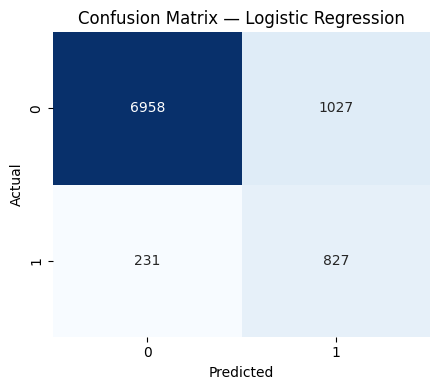

In [30]:

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



### Precision & Recall vs Threshold — Logistic Regression

This curve shows how **precision** and **recall** change as we vary the probability threshold.  
Use it to pick a threshold that fits your business objective (e.g., maximize recall with a minimum precision).


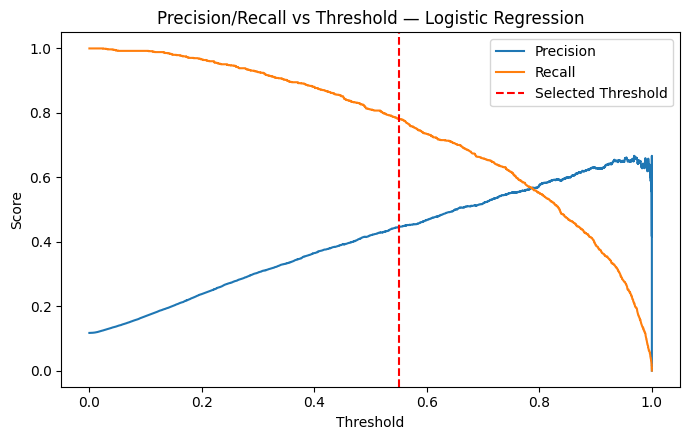

In [31]:

precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test, y_prob_lr)

plt.figure(figsize=(7, 4.5))
plt.plot(thresholds_lr, precisions_lr[:-1], label='Precision')
plt.plot(thresholds_lr, recalls_lr[:-1], label='Recall')
plt.axvline(x=threshold_lr, color='red', linestyle='--', label='Selected Threshold')
plt.title('Precision/Recall vs Threshold — Logistic Regression')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()



## 9) Batch Scoring on Another File (`bank.csv`)

We load a second file (same schema) and score it with the **trained logistic regression pipeline**.  
- We drop the target column `y` from features and keep it separately (if present) to check actual vs predicted.  
- The **same preprocessing** learned on the training data is applied automatically by the pipeline.


In [32]:

# Path to batch file (adjust as needed)
batch_path = "bank\\bank.csv"

# Read batch input (semicolon-delimited as well)
batch_input = pd.read_csv(batch_path, sep=";")

# Keep a copy of actuals if `y` exists; map to numeric for comparison
y_actual = None
if 'y' in batch_input.columns:
    y_actual = batch_input['y'].map({'yes': 1, 'no': 0})
    batch_features = batch_input.drop('y', axis=1)
else:
    batch_features = batch_input.copy()

# Predict probabilities and hard labels with the same threshold
batch_prob_lr = pipeline_lreg.predict_proba(batch_features)[:, 1]
batch_pred_lr = (batch_prob_lr >= threshold_lr).astype(int)

# Assemble results for inspection
results_lr = batch_features.copy()
if y_actual is not None:
    results_lr['Actual'] = y_actual
results_lr['Predicted'] = batch_pred_lr
results_lr['Probability'] = batch_prob_lr

print("Batch results (first 10 rows):")
display(results_lr.head(10))


Batch results (first 10 rows):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Actual,Predicted,Probability
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0,1,0.550018
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0,0,0.154181
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0,0,0.468601
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0,0,0.058419
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0,0,0.037832
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,0,1,0.562331
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,0,0,0.456202
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,0,0,0.123551
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,0,0,0.017903
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,0,0,0.256644



## 10) LightGBM with SMOTE (on Preprocessed Features)

Why this detour? **SMOTE works in numeric feature space**, so we must first transform the raw features using the **same preprocessor** as before. Steps:

1. **Fit** the `preprocessor` on `X_train` and **transform** both train and test to numeric matrices.  
2. Apply **SMOTE** to oversample the minority class **only on the training fold** (never on test).  
3. Train a **LightGBM** classifier on the resampled training data.  
4. Tune decision **threshold** to achieve at least a target recall (here, `≥ 0.70`) while maximizing precision among those thresholds.


Shape after preprocessing (train): (36168, 42)

Before SMOTE:
 y
0    31937
1     4231
Name: count, dtype: int64

After SMOTE:
 y
0    31937
1    31937
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10527
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Optimal Threshold (LightGBM): 0.41300629396123756

--- LightGBM + SMOTE: Test Metrics ---
Precision: 0.5597
Recall   : 0.7042
ROC AUC  : 0.9312


C:\Users\TS0705\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


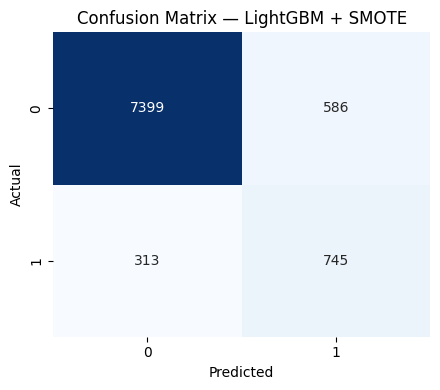

In [33]:

# 1) Transform raw features to numeric matrices
X_train_transformed = preprocessor.fit_transform(X_train)  # fits encoders/scalers on training data
X_test_transformed  = preprocessor.transform(X_test)       # applies the learned transforms to test data

print("Shape after preprocessing (train):", X_train_transformed.shape)

# 2) Apply SMOTE on the transformed training data ONLY
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

print("\nBefore SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())

# 3) Train LightGBM on the resampled training data
lgb_model = LGBMClassifier(
    class_weight='balanced',  # can help if residual imbalance or misclassification costs remain
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    random_state=RANDOM_STATE,
)
lgb_model.fit(X_train_res, y_train_res)

# 4) Predict probabilities on the untouched test set
y_prob_lgb = lgb_model.predict_proba(X_test_transformed)[:, 1]

# Compute precision/recall vs thresholds
precisions_lgb, recalls_lgb, thresholds_lgb = precision_recall_curve(y_test, y_prob_lgb)

# We want recall >= 0.70, and among those thresholds, pick the one with the highest precision.
# thresholds_lgb has length len(precisions_lgb)-1; compare only up to that length.
mask = (recalls_lgb[:-1] >= 0.70)

if mask.any():
    # Among valid thresholds (recall >= 0.70), choose index with max precision
    candidate_precisions = precisions_lgb[:-1] * mask
    best_idx = int(np.argmax(candidate_precisions))
    optimal_threshold = float(thresholds_lgb[best_idx])
else:
    # Fallback: if no threshold reaches the desired recall, use Youden's J best ROC point
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_lgb)
    youden = tpr - fpr
    optimal_threshold = float(roc_thresholds[int(np.argmax(youden))])
    print("Note: No threshold achieved recall >= 0.70; using ROC Youden's J threshold instead.")

print("Optimal Threshold (LightGBM):", optimal_threshold)

y_pred_lgb = (y_prob_lgb >= optimal_threshold).astype(int)

print("\n--- LightGBM + SMOTE: Test Metrics ---")
print("Precision:", round(precision_score(y_test, y_pred_lgb), 4))
print("Recall   :", round(recall_score(y_test, y_pred_lgb), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob_lgb), 4))

# Confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix — LightGBM + SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



## 11) Notes & Caveats

- **Thresholds drive the precision/recall trade‑off.** Always pick them based on business cost/benefit.  
- **Do not apply SMOTE to the test set.** It should simulate real‑world data.  
- Using both **`class_weight='balanced'`** and **SMOTE** is acceptable, but consider your metric and data;
  sometimes class weights alone or SMOTE alone is preferable — validate via cross‑validation.  
- For production, wrap preprocessing and models into a unified pipeline (e.g., `Pipeline` or `skops` artifacts)
  and persist them to versioned storage.
